In [1]:
import sys
import numpy as np
from scipy.sparse import load_npz
import pickle

sys.path.insert(0,'..')
import src.scMKL_src as src
import src.scMKL_util as util

In [2]:
seed = np.random.default_rng(100)

rna_X = load_npz('data/MCF7_RNA_X.npz')
atac_X = load_npz('data/MCF7_ATAC_X.npz')

rna_features = np.load('data/MCF7_RNA_feature_names.npy', allow_pickle= True)
atac_features = np.load('data/MCF7_ATAC_feature_names.npy', allow_pickle= True)

labels = np.load('data/MCF7_cell_labels.npy', allow_pickle= True)

with open('data/MCF7_feature_groupings.pkl', 'rb') as fin:
    feature_groups = pickle.load(fin)



In [3]:
rna_group_dict = {}
atac_group_dict = {}

for pathway in feature_groups.keys():
    rna_group_dict[pathway] = feature_groups[pathway]['genes']
    atac_group_dict[pathway] = feature_groups[pathway]['peaks']

rna_X, rna_features = src.Filter_Features(X = rna_X, feature_set= rna_features, group_dict= rna_group_dict)
atac_X, atac_features = src.Filter_Features(atac_X, atac_features, atac_group_dict)

D = int(np.sqrt(len(labels)) * np.log(np.log(len(labels))))

In [4]:
train_indices, test_indices = src.Train_Test_Split(labels, seed_obj= seed)

y_train = labels[train_indices]
y_test = labels[test_indices]

rna_sigmas = src.Estimate_Sigma(X= rna_X[train_indices,:], group_dict= rna_group_dict, assay= 'rna', feature_set= rna_features, distance_metric= 'euclidean', seed_obj= seed)
atac_sigmas = src.Estimate_Sigma(X= atac_X[train_indices,:], group_dict= atac_group_dict, assay= 'atac', feature_set= atac_features, distance_metric= 'cityblock', seed_obj= seed)


rna_sigmas = src.Optimize_Sigma(X = rna_X[train_indices,:], y = y_train, group_dict = rna_group_dict, assay = 'rna', D = D, feature_set = rna_features, 
                            sigma_list =rna_sigmas, kernel_type= 'Gaussian', k = 4, sigma_adjustments = np.arange(0.1,2.1,0.5), seed_obj= seed)
atac_sigmas = src.Optimize_Sigma(X = atac_X[train_indices,:], y = y_train, group_dict = atac_group_dict, assay = 'atac', D = D, feature_set = atac_features, 
                            sigma_list = atac_sigmas, kernel_type = 'Laplacian', k = 4, sigma_adjustments = np.arange(0.1,2.1,0.5), seed_obj= seed)

In [5]:
rna_Z_train, rna_Z_test = src.Calculate_Z(X_train= rna_X[train_indices,:], X_test= rna_X[test_indices,:], group_dict= rna_group_dict, assay= 'rna', D= D, 
                                          feature_set= rna_features, sigma_list= rna_sigmas, kernel_type = 'Gaussian', seed_obj= seed)
atac_Z_train, atac_Z_test = src.Calculate_Z(X_train= atac_X[train_indices,:], X_test= atac_X[test_indices,:], group_dict= atac_group_dict, assay= 'atac', D= D, 
                                  feature_set= atac_features, sigma_list= atac_sigmas, kernel_type = 'Laplacian', seed_obj= seed)

combined_Z_train, combined_Z_test, combined_group_names = src.Combine_Modalities(Assay_1_name= 'rna', Assay_2_name= 'atac',
                                                           Assay_1_Group_Names= rna_group_dict.keys(), Assay_2_Group_Names= atac_group_dict.keys(),
                                                           Assay_1_Z_train= rna_Z_train, Assay_2_Z_train= atac_Z_train,
                                                           Assay_1_Z_test= rna_Z_test, Assay_2_Z_test= atac_Z_test)

In [6]:
tested_alpha,opt_alpha = src.Optimize_Alpha(X_train = combined_Z_train, y_train = y_train, group_size= 2 * D, starting_alpha= 2.9, target = 5, n_iter= 10)
print(tested_alpha)
print(opt_alpha)

{2.9: 0, 2.7: 1, 2.5: 1, 2.3: 2, 2.1: 2, 1.9: 3, 1.7: 4, 1.5: 6}
1.7


In [7]:
norm_dict = {}
metric_dict = {}
for alpha in np.round(np.linspace(opt_alpha, 0.1, 10),2):
    model = src.Train_Model(combined_Z_train, y_train, 2 * D, alpha = alpha)
    predictions, metric_dict[alpha] = src.Predict(model, combined_Z_test, y_test, metrics = ['AUROC', 'F1-Score', 'Accuracy', 'Precision', 'Recall'])
    selected_groups = src.Find_Selected_Pathways(model, group_names= combined_group_names)
    norm_dict[alpha] = [np.linalg.norm(model.coef_[i * 2 * D: (i + 1) * 2 * D - 1]) for i in np.arange(len(combined_group_names))]

In [8]:
print(metric_dict)
print(selected_groups)

{1.7: {'AUROC': 0.961, 'Accuracy': 0.9, 'F1-Score': 0.8969072164948454, 'Precision': 0.925531914893617, 'Recall': 0.87}, 1.52: {'AUROC': 0.9656, 'Accuracy': 0.905, 'F1-Score': 0.9015544041450777, 'Precision': 0.9354838709677419, 'Recall': 0.87}, 1.34: {'AUROC': 0.9693, 'Accuracy': 0.92, 'F1-Score': 0.9175257731958764, 'Precision': 0.9468085106382979, 'Recall': 0.89}, 1.17: {'AUROC': 0.973, 'Accuracy': 0.925, 'F1-Score': 0.9230769230769231, 'Precision': 0.9473684210526315, 'Recall': 0.9}, 0.99: {'AUROC': 0.9752, 'Accuracy': 0.925, 'F1-Score': 0.922279792746114, 'Precision': 0.956989247311828, 'Recall': 0.89}, 0.81: {'AUROC': 0.9792, 'Accuracy': 0.935, 'F1-Score': 0.9326424870466321, 'Precision': 0.967741935483871, 'Recall': 0.9}, 0.63: {'AUROC': 0.9804, 'Accuracy': 0.94, 'F1-Score': 0.9381443298969071, 'Precision': 0.9680851063829787, 'Recall': 0.91}, 0.46: {'AUROC': 0.9831, 'Accuracy': 0.945, 'F1-Score': 0.9430051813471503, 'Precision': 0.978494623655914, 'Recall': 0.91}, 0.28: {'AUROC

/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/mizani/scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/mizani/scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


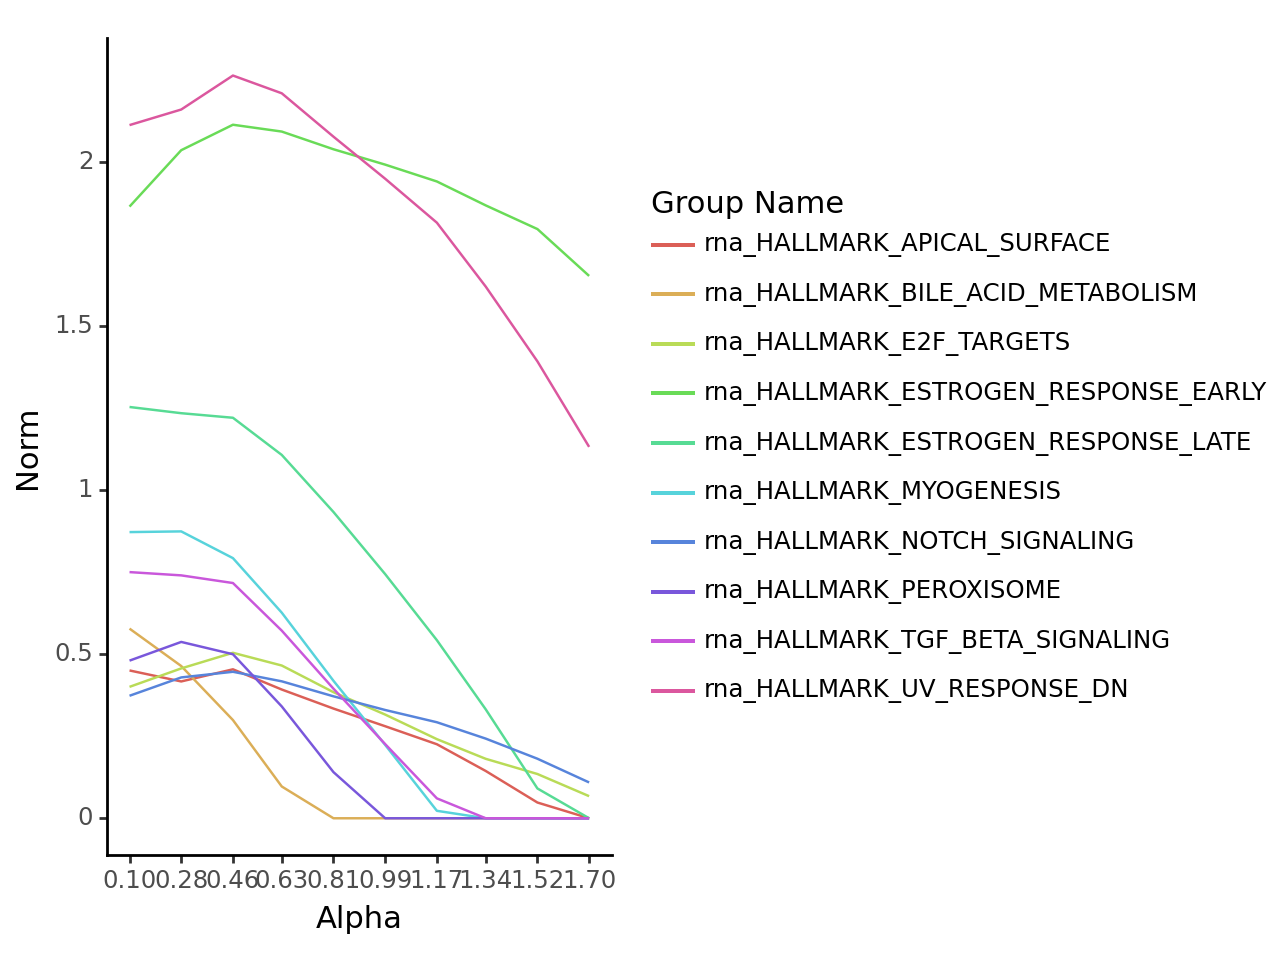

<Figure Size: (640 x 480)>

In [9]:
util.plot_group_norms(norm_dict= norm_dict, group_names= combined_group_names, groups_to_display= 10)

/mnt/c/Users/kupp/Documents/scMKL_pkg/scMKL/example/../src/scMKL_util.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['AUROC', 'Accuracy', 'F1-Score', 'Precision', 'Recall']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/skupp/miniconda3/envs/scMKL_test/lib/python3.11/site-packages/mizani/scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

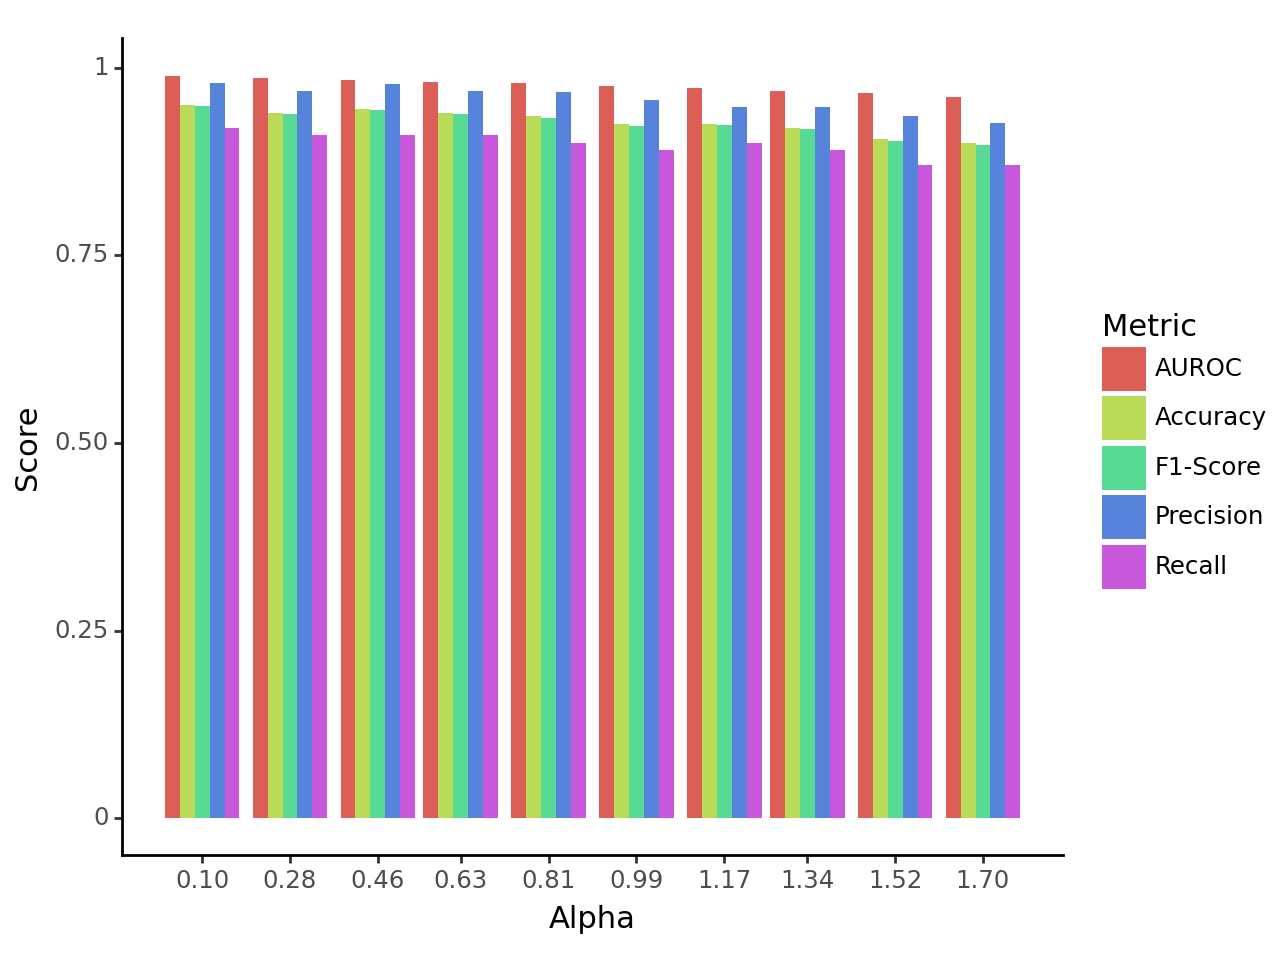

<Figure Size: (640 x 480)>

In [10]:
util.plot_classification_metrics(metric_dict)